## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

sc212zw

Your full name:

Ziwei Wang

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
# ! pip install natsort
# ! pip install seaborn


import cv2
import math

import torch
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from natsort import natsorted

from sklearn.metrics import confusion_matrix
import seaborn as sns

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# ! cp "/content/gdrive/MyDrive/Colab Notebooks/data.zip" "data.zip"

# ! unzip data.zip

In [2]:
# dataset = ImageFolder(root="data/train_set/train_set/", transform=transforms.ToTensor())
dataset = ImageFolder(root="data/train_set/train_set", transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8,pin_memory=True)

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool.

In [3]:
# TO COMPLETE
# define a Model class

class Simple_CNN(nn.Sequential):
    def __init__(self):
        super().__init__()
        layers = [    
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3),    
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3),    
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*13*13,512),
            nn.ReLU(),
            nn.Linear(512,30),
            nn.LogSoftmax(dim=1),
        ]
        for idx, module in enumerate(layers):
            self.add_module(str(idx), module)

### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.

In [4]:
class Foundation_Classification():
    def __init__(self, dataloader):    
        self.batch_size = dataloader.batch_size
        self.stat = {"train_loss":[], "validation_loss":[]}
        self.results_path = '_batch.pt'
        self.dataloader = dataloader
        self.epoch_size = len(self.dataloader)
        
    def simple_fig_init(self):     
        self.net = Simple_CNN().to(device)
        self.loss_fn = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.001)
        
    def accuracy(self, outputs, labels):
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        return correct/labels.shape[0]
    
    def train(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self.net(inputs.to(device))
        loss = self.loss_fn(outputs, labels.to(device))
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, inputs):
        with torch.no_grad():
          output = int(torch.argmax(self.net(inputs.to(device))))
        return output

    def validate(self, inputs, labels):
        with torch.no_grad():
          outputs = self.net(inputs.to(device)).to(device)
          loss = self.loss_fn(outputs, labels.to(device)).item()
        return loss
    
    def plot(self):
        plt.plot(self.stat["train_loss"], 'r', label = 'training loss', )
        plt.plot(self.stat["validation_loss"], 'g', label = 'validation loss' )
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training and test loss')

In [5]:
class Single_Batch(Foundation_Classification):
    def __init__(self, dataloader, validation_ratio=0.2):
        super().__init__(dataloader)
        self.validation_ratio = validation_ratio
        self.validation_index = int(self.batch_size * (1 - self.validation_ratio))
        self.simple_fig_init()
    
    def training(self): 
        data = next(iter(self.dataloader))
        inputs, labels = data
        train_inputs = inputs[:self.validation_index]
        validation_inputs = inputs[self.validation_index:]
        train_labels = labels[:self.validation_index]
        validation_labels = labels[self.validation_index:]
        train_loss = 999
        
        epoch = 0
        
        while round(train_loss,3) != 0.0:

            train_loss = self.train(train_inputs, train_labels)
            validation_loss = self.validate(validation_inputs, validation_labels)

            self.stat["train_loss"].append(train_loss)
            self.stat["validation_loss"].append(validation_loss)
            # print(f"epoch: {epoch} training loss: {train_loss: .3f} validation loss: {validation_loss: .3f}")
            epoch += 1
            
        torch.save({"single_state_dict": self.net.state_dict()}, "singe"+self.results_path)

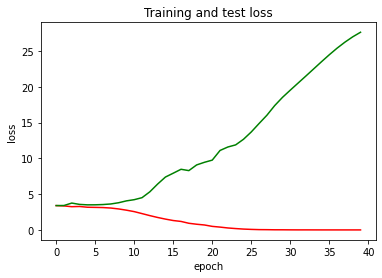

In [6]:
s = Single_Batch(dataloader)
s.training()
s.plot()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.

In [7]:
# TO COMPLETE
class Complete_Dataset(Foundation_Classification):
    def __init__(self, dataloader, fig=False):
        super().__init__(dataloader)
        if not fig:
            self.complete_fig_init(lr=0.002)

    def complete_fig_init(self, lr=0.001, step_size=5):     
        self.net = Simple_CNN().to(device)
        self.loss_fn = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.step_size = step_size
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=0.5)
        self.need_test = False
        
    def scheduler_step(self, max_scheduler_step, c_condition):
        if c_condition and max_scheduler_step >= 0:
            self.scheduler.step()
            return max_scheduler_step - 1
        return max_scheduler_step
        

    def training(self, epoch_max, k_fold=8, total_step=10):

        validation_size = int(self.epoch_size / k_fold)
        max_scheduler_step = total_step
        last_loss = None

        for epoch in range(epoch_max):
            batch_count = 0
            train_loss = 0.0
            validation_loss = 0.0
            validation_idx1 = (epoch % k_fold) * validation_size
            validation_idx2 = ((epoch % k_fold) + 1) * validation_size

            for inputs, labels in self.dataloader:
                if batch_count < validation_idx1 or batch_count >= validation_idx2:
                    loss = self.train(inputs, labels)
                    train_loss += loss/ (self.epoch_size - validation_size)
                else:
                    loss = self.validate(inputs, labels)
                    validation_loss += loss/ validation_size
                batch_count +=1

            if self.scheduler and last_loss and max_scheduler_step >= 0:
                max_scheduler_step = self.scheduler_step(max_scheduler_step, last_loss <= train_loss)

            last_loss = train_loss

            self.stat["train_loss"].append(train_loss)
            self.stat["validation_loss"].append(validation_loss)
            if epoch % 10 == 0:
                print(f"epoch: {epoch} training loss: {train_loss: .3f} validation loss: {validation_loss: .3f}")

            if round(train_loss,3) == 0:
                break
            else:
                epoch += 1
                
            if self.need_test and epoch % 50 == 0:
                test(self, test_dataloader)
        torch.save({"state_dict": self.net.state_dict()}, "complete"+self.results_path)

In [8]:
c = Complete_Dataset(dataloader)
c.training(300)

epoch: 0 training loss:  3.228 validation loss:  3.402
epoch: 10 training loss:  1.701 validation loss:  1.702
epoch: 20 training loss:  0.492 validation loss:  0.536
epoch: 30 training loss:  0.137 validation loss:  0.112
epoch: 40 training loss:  0.037 validation loss:  0.073
epoch: 50 training loss:  0.001 validation loss:  0.001


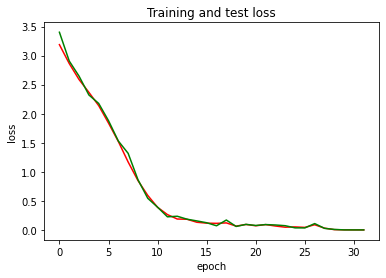

In [9]:
c.plot()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.

**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.

In [9]:
# TO COMPLETE
class model_122a(nn.Sequential):
    def __init__(self):
        super().__init__()
        layers = [    
            nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3),    
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3),    
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(64*13*13,512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512,30),
            nn.LogSoftmax(dim=1),
        ]
        for idx, module in enumerate(layers):
            self.add_module(str(idx), module)


class Fine_tune(Complete_Dataset):
    def __init__(self, dataloader):
        super().__init__(dataloader, fig=True)
        self.fine_fig_init()

    def fine_fig_init(self, lr=0.002, step_size=80):  
        self.net = model_122a().to(device)
        self.loss_fn = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.step_size = step_size
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=0.5)
        self.need_test = False
        
    def fine_fig_reset(self, lr=0.001, step_size=100):
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.step_size = step_size
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=0.5)
        
    def set_dataloader(self, dataloader):
        self.dataloader = dataloader
        self.batch_size = dataloader.batch_size
        
    def scheduler_step(self, max_scheduler_step, c_condition):
        self.scheduler.step()
        return max_scheduler_step - 1


In [11]:
f = Fine_tune(dataloader)
f.training(200, total_step=160)

epoch: 0 training loss:  3.351 validation loss:  3.401
epoch: 10 training loss:  2.009 validation loss:  1.930
epoch: 20 training loss:  1.205 validation loss:  1.271
epoch: 30 training loss:  0.806 validation loss:  0.822
epoch: 40 training loss:  0.596 validation loss:  0.560
epoch: 50 training loss:  0.457 validation loss:  0.399
epoch: 60 training loss:  0.383 validation loss:  0.375
epoch: 70 training loss:  0.339 validation loss:  0.391
epoch: 80 training loss:  0.308 validation loss:  0.270
epoch: 90 training loss:  0.183 validation loss:  0.159
epoch: 100 training loss:  0.170 validation loss:  0.163
epoch: 110 training loss:  0.152 validation loss:  0.168
epoch: 120 training loss:  0.154 validation loss:  0.143
epoch: 130 training loss:  0.135 validation loss:  0.120
epoch: 140 training loss:  0.141 validation loss:  0.111
epoch: 150 training loss:  0.124 validation loss:  0.091
epoch: 160 training loss:  0.113 validation loss:  0.130
epoch: 170 training loss:  0.084 validatio

In [12]:
f_transforms = transforms.Compose([
      transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
      transforms.RandomRotation(degrees=180),
      transforms.ToTensor()
    ])
f_dataset = ImageFolder(root="data/train_set/train_set", transform=f_transforms)
f_dataloader = DataLoader(f_dataset, batch_size=128, shuffle=True, num_workers=20, pin_memory=True)

f.set_dataloader(f_dataloader)
f.fine_fig_reset()
f.training(300, total_step=200)

epoch: 0 training loss:  4.207 validation loss:  12.312
epoch: 10 training loss:  2.675 validation loss:  2.722
epoch: 20 training loss:  2.509 validation loss:  2.508
epoch: 30 training loss:  2.407 validation loss:  2.388
epoch: 40 training loss:  2.317 validation loss:  2.364
epoch: 50 training loss:  2.277 validation loss:  2.276
epoch: 60 training loss:  2.218 validation loss:  2.229
epoch: 70 training loss:  2.168 validation loss:  2.224
epoch: 80 training loss:  2.135 validation loss:  2.161
epoch: 90 training loss:  2.082 validation loss:  2.113
epoch: 100 training loss:  2.053 validation loss:  2.064
epoch: 110 training loss:  1.992 validation loss:  1.998
epoch: 120 training loss:  1.956 validation loss:  1.973
epoch: 130 training loss:  1.965 validation loss:  1.898
epoch: 140 training loss:  1.930 validation loss:  1.900
epoch: 150 training loss:  1.912 validation loss:  1.909
epoch: 160 training loss:  1.893 validation loss:  1.889
epoch: 170 training loss:  1.870 validati

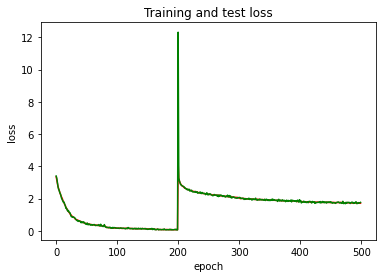

In [13]:
# instantiate your new Model class
# model_122
f.plot()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2).

In [20]:
def plot_comparsison(s, c, f):
    fig, axs = plt.subplots(3, sharex=True, sharey=True)

    plt.title('training comparision')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    axs[0].plot(s.stat["train_loss"], 'r', label = 'training loss')
    axs[0].plot(s.stat["validation_loss"], 'b', label = 'validation_loss')

    axs[1].plot(c.stat["train_loss"], 'r', label = 'training loss')
    axs[1].plot(c.stat["validation_loss"], 'b', label = 'validation_loss')

    axs[2].plot(f.stat["train_loss"], 'r', label = 'training loss')
    axs[2].plot(f.stat["validation_loss"], 'b', label = 'validation_loss')

    plt.plot()

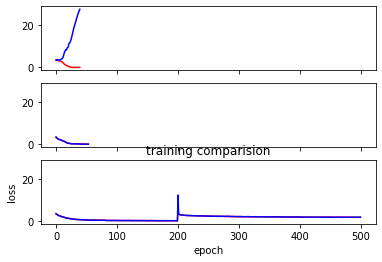

In [21]:
plot_comparsison(s, c, f)

In the single batch training, the validation loss goes the opposite direction as the training loss reach zero in the relatively short amount of epoch taken.


While using the complete dataset, the validation loss has similar trends with the corresponding training loss. Nevertheless, there is a shape reduction in both loss curves in the early stage of the training process.


With finetuning, I use the original data in the adjusted model for the first 200 epochs. Then the augmented data for another 300 epochs. We can see a rapid increase in the loss when changing the dataset. However, the training and validation losses go down with a smoother curve. In contrast, those two loss curves do not reach zero and slowly go down in a fluctuated way.


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.

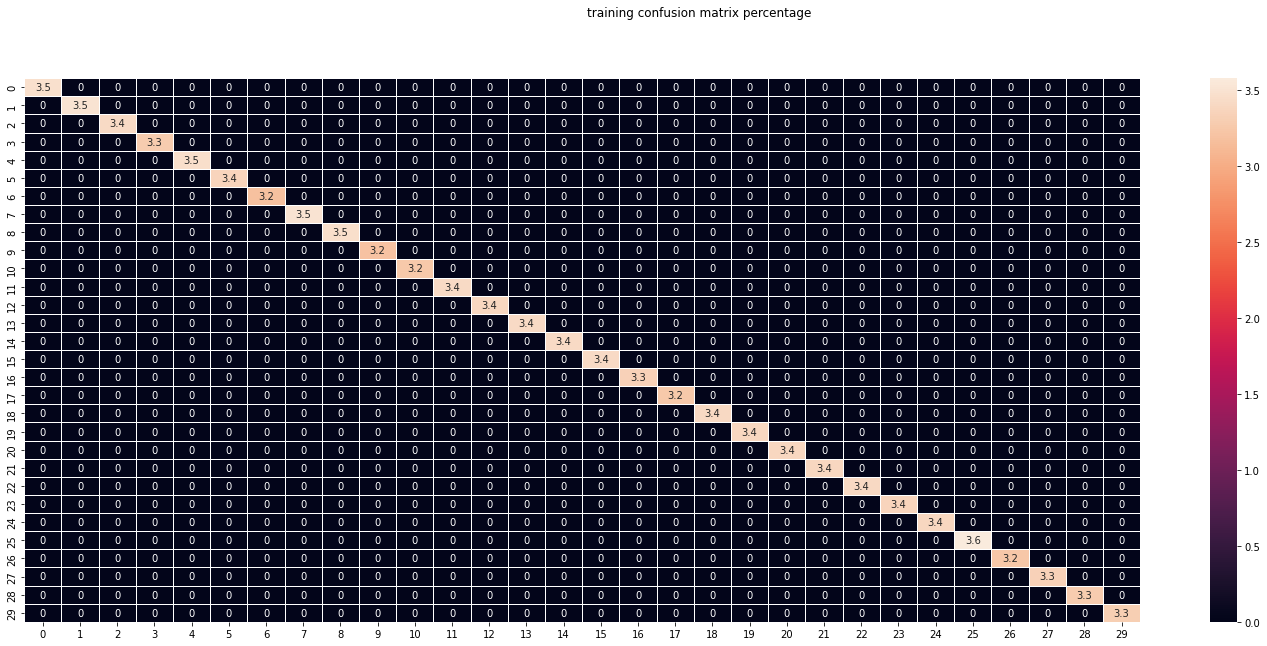

In [15]:
# TO COMPLETE
def plot_conf(model, dataloader, figsize=(25,10), train=True) :
    validation_batch = int(len(model.dataloader) * (1 - 0.2))
    train_pred = np.array([])
    train_true = np.array([])
    validation_pred = np.array([])
    validation_true = np.array([])
    batch_count = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model.net(inputs.to(device)).to(torch.device("cpu"))
            _, pred = torch.max(outputs.data, 1)
            if batch_count <= validation_batch:
                train_pred = np.append(train_pred, pred)
                train_true = np.append(train_true, labels)
            else:
                validation_pred = np.append(validation_pred, pred)
                validation_true = np.append(validation_true, labels)
            batch_count +=1
    
    if train:
        cm = confusion_matrix(train_true, train_pred)
        cm = cm / (model.batch_size * validation_batch) * 100
        fig_name = "training"
    else:
        cm = confusion_matrix(validation_true, validation_pred)        
        cm = cm / (model.batch_size * (len(model.dataloader) - validation_batch)) * 100
        fig_name = "validation"
        
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    fig.suptitle(fig_name + " confusion matrix percentage")
    f = sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

plot_conf(c, dataloader, train=True)

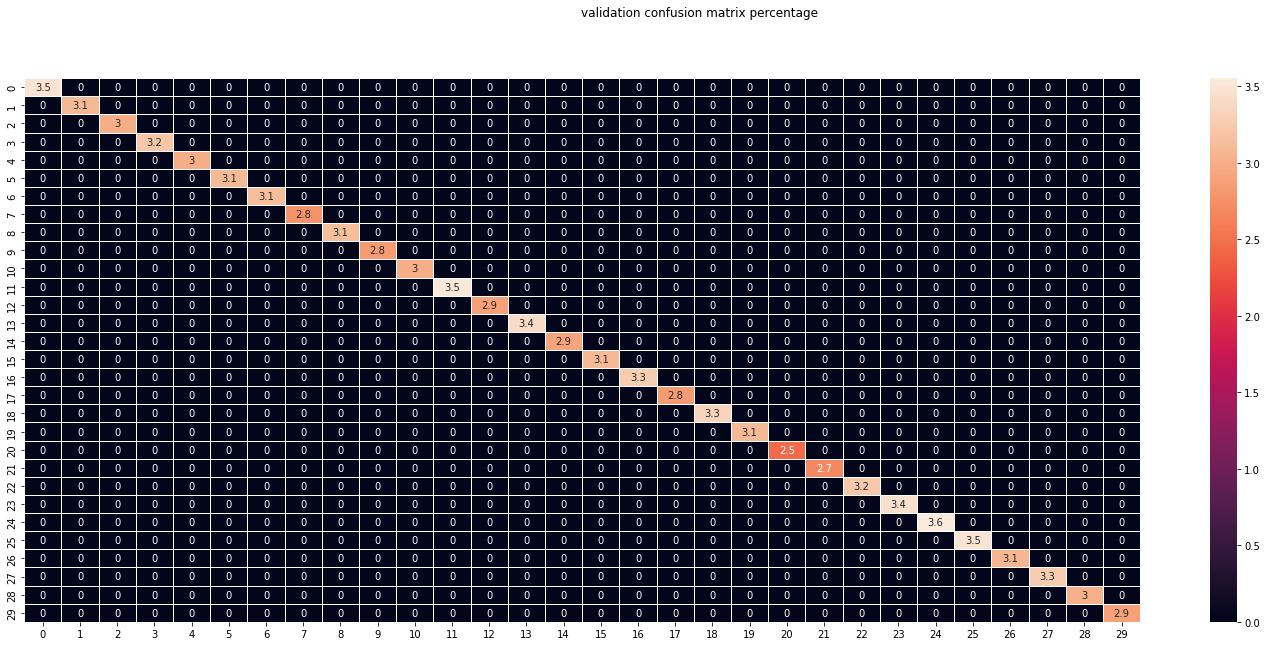

In [16]:
plot_conf(c, dataloader, train=False)

What conclusions can be drawn from the confusion matrices?

The architecture used in the graph is already reached zero in both training and validation loss. In addition, I use cross-validation to split the train and validation set. In this case, all the inputs are corrected. As a result, the confusion matrix can only show the distribution of the image classes. The confusion matrix is shown as an identity matrix with main diagonal filled with non-zero attributes while others are zero.



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model.

In [ ]:
# TO COMPLETE

In [15]:
class Test_Dataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])

        image = Image.open(img_loc).convert("RGB")
        id = self.total_imgs[idx]
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]

In [16]:
# test_dataset = Test_Dataset("data/test_set/test_set", transform=f_transforms)
test_dataset = Test_Dataset("data/test_set/test_set", transform=transforms.ToTensor())

test_dataloader = DataLoader(test_dataset)


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).

In [17]:
# TO COMPLETE
import csv

In [18]:
def test(model, dataloader):
    with open("sc212zw.csv", "w") as output_file:
        output_writer = csv.writer(output_file)
        output_writer.writerow(["Id","Category"])

        for test_inputs, test_id in dataloader:
            tets_output = model.predict(test_inputs)
            output_writer.writerow([test_id[0], tets_output])

In [19]:
test(f, test_dataloader)



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).

### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis

### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [47]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [48]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [49]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [50]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.

In [51]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    # TO COMPLETE
    # return filters
    return model.features[layer_idx].weight

In [52]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [53]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [54]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale.

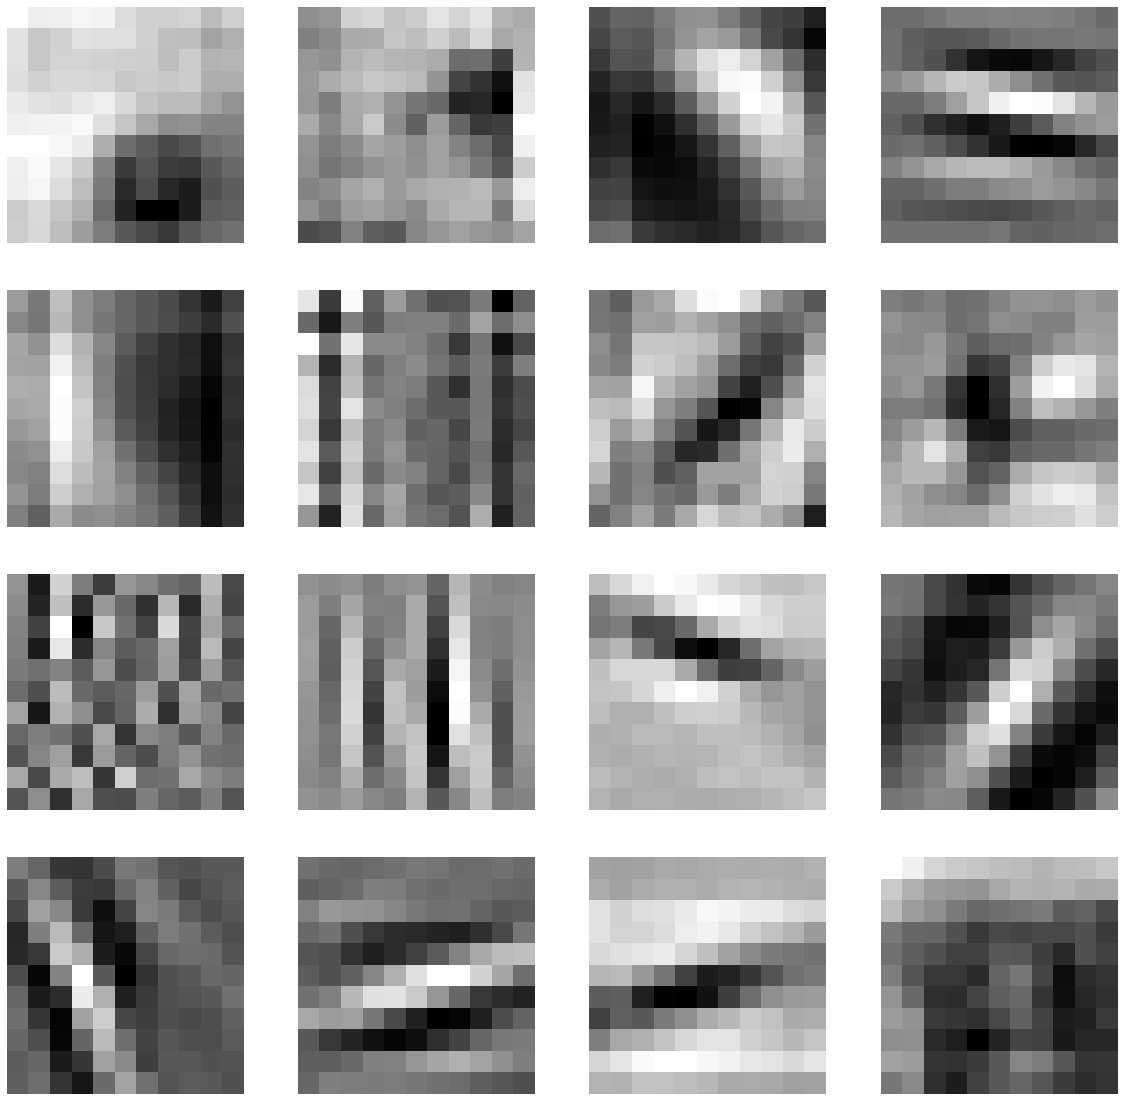

In [55]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].detach().numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.

### 2.2.1 Load test image [1 mark]

In [56]:
# TO COMPLETE
# ! mkdir image
# ! cp "/content/gdrive/MyDrive/Colab Notebooks/man_bike.JPEG" "image/man_bike.JPEG"

im = Image.open("../input/something-2/man_bike.JPEG").convert("RGB")

Run the code cell below to apply the image transformation expected by the model.

In [57]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [58]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """

    # TO COMPLETE
    conv_layer_idx = [2, 5, 11]

    filters = []

    for layer_idx in range(len(model.features)):
        image = model.features[layer_idx](image)
        if layer_idx in conv_layer_idx:
            filters.append(image)
    return filters

In [59]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [60]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

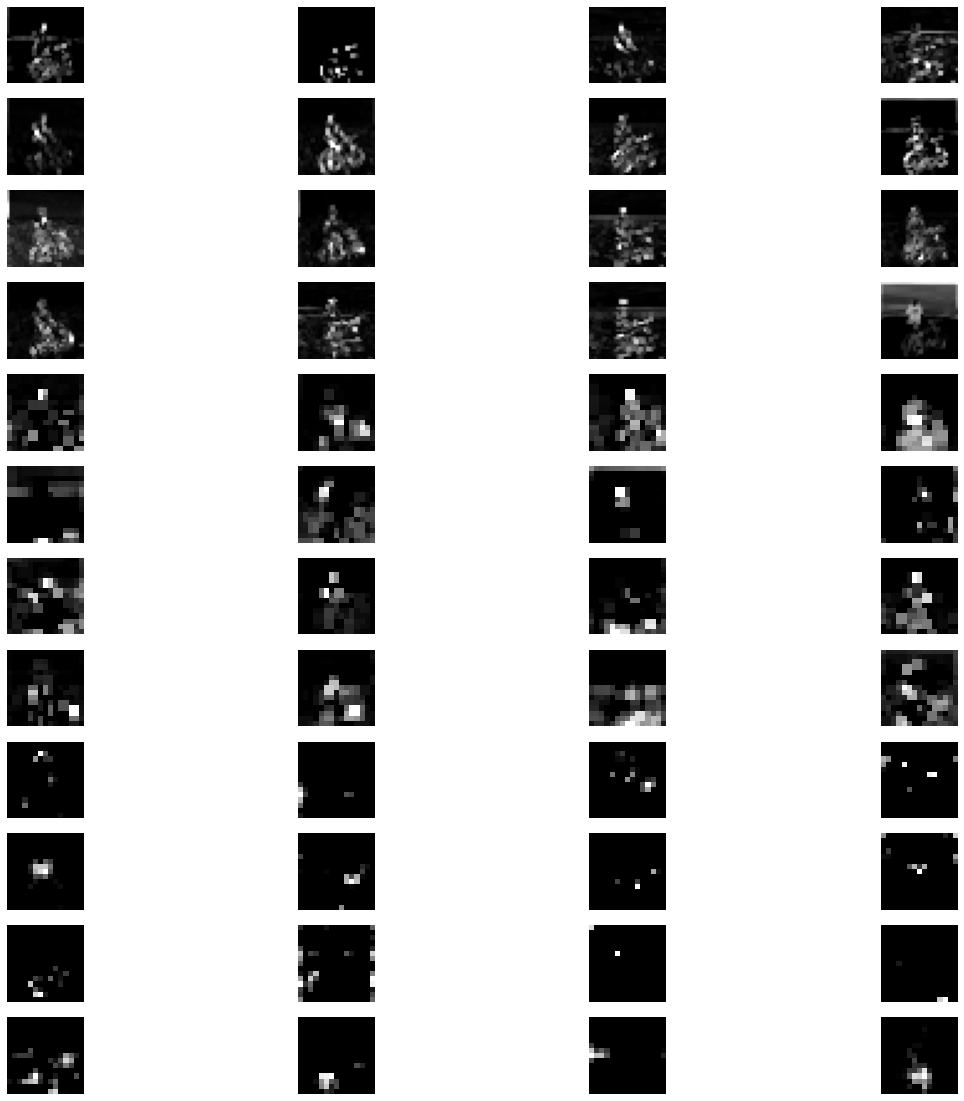

In [61]:
# TO COMPLETE
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

plt.rcParams["figure.figsize"] = (20,20)

# plot the first channel of each filter in a grid
for feature_idx in range(3):
  for i, filt in enumerate(feature_maps[feature_idx][0].detach().numpy()[:to_show]):
    plt.subplot(3*plt_dim, plt_dim , (16* feature_idx + i+1))
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
plt.show()




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).

The first filters detect the shape or the outlines of the image. We can recognise the shape of the people in the middle with his bicycle in most of the filters from the first three rows of filters shown above.

Processing to the second filters, in this level, most of the filters are blurred or shown as mosaic particles. We can still detect the board outline of the people. For example, the filter at the fifth-row third column can see the head as the brightest part and his body in the slightly darker parts. 

As for the last filters, there is an only main focus in each filter. In the filter of the first column, tenth row, the light area at the middle indicts the people.

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

The number of filters grows from 64 to 384 in the early stage then decreases from 384 to 256. Less detail is shown in each filter, while each focuses on one specific detail.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

The feature maps are the output of filters. That is, the more specific focus, the more blurred image. Inrelvence details are being discarded as going deeper into the networks, and the feature maps are shown as focus on specific details.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [62]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [63]:
model = alexnet(pretrained=True)

In [64]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [65]:
pred_cls

tensor([[671]])

### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [66]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    loss = nn.CrossEntropyLoss()(output, class_id[0]).backward()

    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE

    gradients = model.gradients

    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image)

    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE


    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.

    zeros = torch.tensor(np.zeros([7,7]))
    heatmap = torch.max(heatmap, zeros)
    
    # TO COMPLETE
    return heatmap

In [67]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

In [68]:
heatmap.shape

torch.Size([7, 7])

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [70]:
# TO COMPLETE
import torchvision.transforms as T
# from google.colab.patches import cv2_imshow

def display(heatmap, image):
    rescale_hm = heatmap / torch.max(heatmap) * 256

    resize_im = T.Resize([image.shape[0],image.shape[1]])(T.ToPILImage()(rescale_hm.detach().numpy().astype(np.uint8)))
    resize_hm = T.ToTensor()(resize_im)

    rescale_hm_2 = (1 - resize_hm / torch.max(resize_hm)) * 256
#     rescale_hm_2 = resize_hm / torch.max(resize_hm) * 256


    modified_hm = (rescale_hm_2).numpy().astype(np.uint8)
    
    colormap_hm = cv2.applyColorMap(modified_hm[0], cv2.COLORMAP_JET)

    merge_img = image.copy()
    alpha = 0.4
    cv2.addWeighted(image, alpha, merge_img, 1-alpha, 0, merge_img)
    cv2.addWeighted(colormap_hm, alpha, merge_img, 1-alpha, 0, merge_img)
    plt.matshow(merge_img)

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

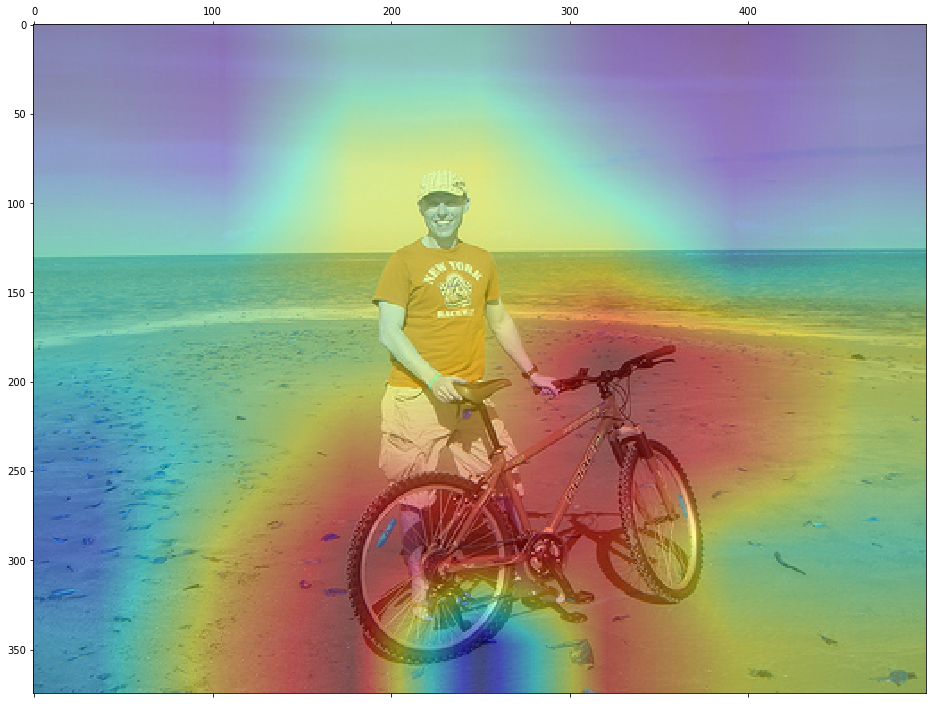

In [71]:
# TO COMPLETE
im = Image.open("../input/something-2/man_bike.JPEG").convert("RGB")
im = data_transform(im)
display(generate_heatmap(model(im.unsqueeze(0)), torch.tensor([[978]]), model, im.unsqueeze(0)), cv2.imread("../input/something-2/man_bike.JPEG"))
# display(heatmap, cv2.imread("image/man_bike.JPEG"))

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [72]:
# TO COMPLETE
f_dir = "../input/something-3/saint_j.jpg"

f_im = Image.open(f_dir).convert("RGB")
f_im = data_transform(f_im)

output = model(f_im.unsqueeze(0))
_, pred_cls = output.max(dim=1, keepdim=True)

pred_cls

tensor([[850]])

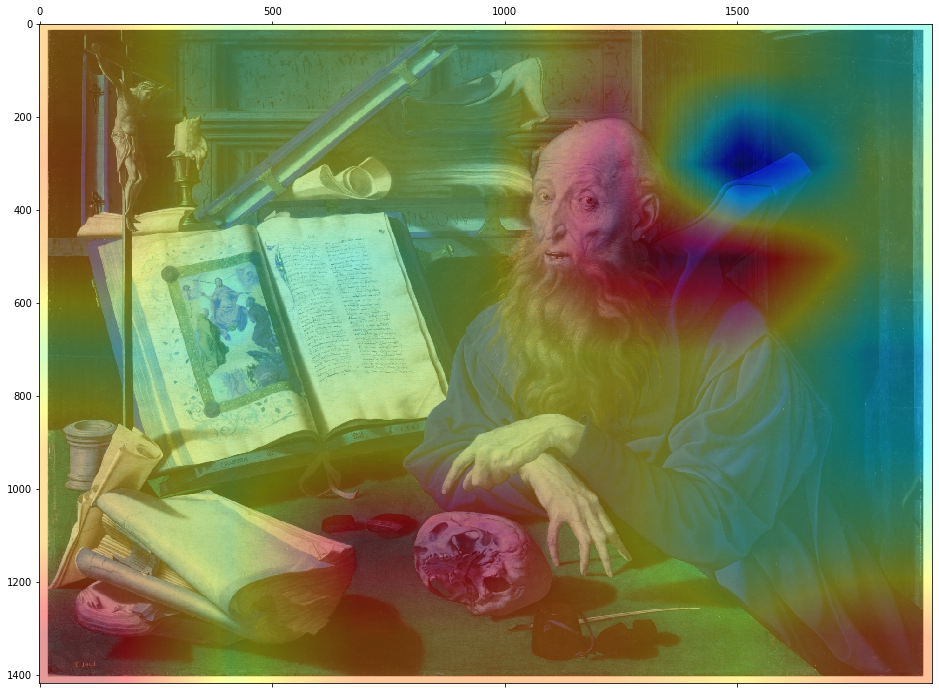

In [73]:
display(generate_heatmap(model(f_im.unsqueeze(0)), pred_cls, model, f_im.unsqueeze(0)), cv2.imread(f_dir))

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

The AlexNet classifies the above image as teddy(index 850 of ImageNet's labels) in which the original image should be Saint Jermore. We can see that the heatmap focuses on the skull and the bone on the table and a strange area near Saint Jermore's neck. This misclassification is caused by the  multiple
symbols are too close. 

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**